In [1]:
#Data Manipulation and Processing
import numpy as np
import pandas as pd

#File Handing and Operation
import os
from pathlib import Path
import re
import glob
import random
from collections import Counter

#Progress bar for loops
from tqdm import tqdm

#Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


#Image Processing Libraries
from PIL import Image


#To suppress warning
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore")



In [2]:
#Tensorflow and Keras Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers, Sequential
from tensorflow.keras.models import Sequential,Model,load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import to_categorical

#Keras layers
from tensorflow.keras.layers import(
Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input,BatchNormalization, ReLU, AveragePooling2D, GlobalAveragePooling2D)

#CallBacks
from tensorflow.keras.callbacks import (EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard, LearningRateScheduler, CSVLogger, TerminateOnNaN, )

#Regularizations
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2, l1, l1_l2

#Optimizers
from tensorflow.keras.optimizers import SGD, RMSprop, Adagrad, Ftrl
from tensorflow.keras.optimizers import Adam, Adamax, Nadam, Adadelta


#Transfer Learning Applications 
from tensorflow.keras.applications import (
VGG19, VGG16, MobileNet, ResNet50, InceptionV3, DenseNet121, Xception, EfficientNetB0, NASNetLarge, NASNetMobile
)

#Mixed Precision
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

#Suppress TensorFlow logging
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  

Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  NVIDIA GeForce GTX 1050, compute capability 6.1
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [3]:
#Data Split and Cross-Validation for Image Data
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold

#Evalution Metrics for Image Classification
from sklearn.metrics import (classification_report, confusion_matrix,
                             precision_score, recall_score, accuracy_score, roc_curve, auc, f1_score, log_loss)

#Label Binarization for Multi-Class Image Classification
from sklearn.preprocessing import label_binarize

#Class Weight Calculation for Imbalanced Image Datasets
from sklearn.utils.class_weight import compute_class_weight

#Model Selection Metrics for Image Classification
from sklearn.metrics import roc_auc_score, matthews_corrcoef

#Additional Image Classification Metrics
from sklearn.metrics import roc_auc_score, matthews_corrcoef

#Additional Image Classification Metrics
from sklearn.metrics import average_precision_score, precision_recall_curve


In [4]:
# Check if GPU is available
print(f'Tensorflow Version: {tf.__version__}')
print("GPU Available:", tf.config.list_physical_devices('GPU')[0])

Tensorflow Version: 2.7.0
GPU Available: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [5]:
os.getcwd()

'C:\\Users\\DIKSHANT PATEL\\Kidney-Disease-Classification\\research'

In [6]:
os.chdir("./..")

In [7]:
os.getcwd()

'C:\\Users\\DIKSHANT PATEL\\Kidney-Disease-Classification'

In [8]:
data_csv_path = "artifacts/data_ingestion"
classes_dir_path = "artifacts/data_ingestion/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone"

In [9]:
classes = os.listdir(classes_dir_path)
classes

['Cyst', 'Normal', 'Stone', 'Tumor']

In [10]:
def make_df(classes,classes_dir_path):
    data = []
    for label in classes:
        folder_path = os.path.join(classes_dir_path,label)
        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)
            data.append((file_path, label))
            
    df = pd.DataFrame(data, columns=['file_path', 'label'])
    return df

In [11]:
df = make_df(classes, classes_dir_path)
df

,file_path,label
0,artifacts/data_ingestion/CT-KIDNEY-DATASET-Nor...,Cyst
1,artifacts/data_ingestion/CT-KIDNEY-DATASET-Nor...,Cyst
2,artifacts/data_ingestion/CT-KIDNEY-DATASET-Nor...,Cyst
3,artifacts/data_ingestion/CT-KIDNEY-DATASET-Nor...,Cyst
4,artifacts/data_ingestion/CT-KIDNEY-DATASET-Nor...,Cyst
...,...,...
12441,artifacts/data_ingestion/CT-KIDNEY-DATASET-Nor...,Tumor
12442,artifacts/data_ingestion/CT-KIDNEY-DATASET-Nor...,Tumor
12443,artifacts/data_ingestion/CT-KIDNEY-DATASET-Nor...,Tumor
12444,artifacts/data_ingestion/CT-KIDNEY-DATASET-Nor...,Tumor


In [12]:
df.sample(12)

,file_path,label
4723,artifacts/data_ingestion/CT-KIDNEY-DATASET-Nor...,Normal
6734,artifacts/data_ingestion/CT-KIDNEY-DATASET-Nor...,Normal
7693,artifacts/data_ingestion/CT-KIDNEY-DATASET-Nor...,Normal
10334,artifacts/data_ingestion/CT-KIDNEY-DATASET-Nor...,Tumor
3501,artifacts/data_ingestion/CT-KIDNEY-DATASET-Nor...,Cyst
8198,artifacts/data_ingestion/CT-KIDNEY-DATASET-Nor...,Normal
4939,artifacts/data_ingestion/CT-KIDNEY-DATASET-Nor...,Normal
12256,artifacts/data_ingestion/CT-KIDNEY-DATASET-Nor...,Tumor
10088,artifacts/data_ingestion/CT-KIDNEY-DATASET-Nor...,Stone
8694,artifacts/data_ingestion/CT-KIDNEY-DATASET-Nor...,Normal


In [13]:
df['label'].value_counts()

label
Normal    5077
Cyst      3709
Tumor     2283
Stone     1377
Name: count, dtype: int64

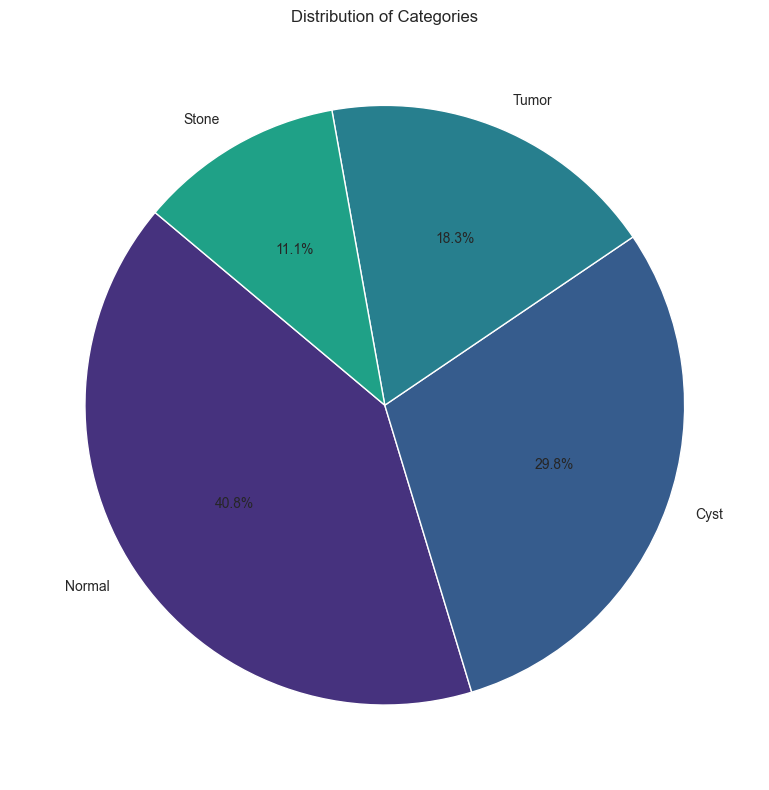

In [16]:
count = df["label"].value_counts()
palette = sns.color_palette("viridis")
colors = palette.as_hex()

plt.figure(figsize = (8,8))
plt.pie(count, labels=count.index, autopct= '%1.1f%%', startangle = 140, colors = colors)

plt.title("Distribution of Categories")
plt.tight_layout()
plt.show()

KeyError: 'percentage'

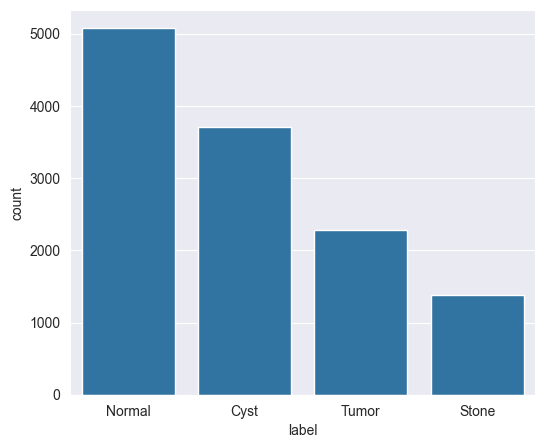

In [17]:
value_counts = df["label"].value_counts().reset_index()
value_counts.columns = ["label", "count"]
value_counts["Percentage"] = (value_counts["count"]/ value_counts["count"].sum() * 100).round(2)

plt.figure(figsize = (6,5))
ax = sns.barplot(data=value_counts, x='label', y='count')
for i, row in value_counts.iterrows():
    ax.text(i, row['count'], f"{row['percentage']}%", ha='center', va='bottom', fontsize=10, color='black')

plt.title("Class Distribution with Percentages")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

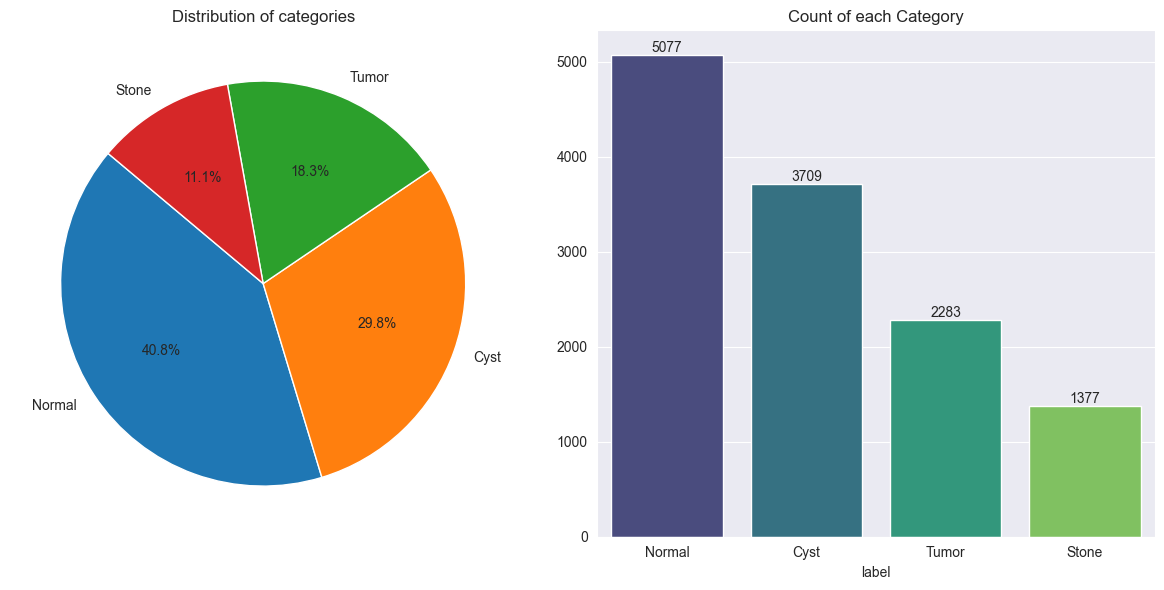

In [18]:
count = df['label'].value_counts()

fig, axs = plt.subplots(1, 2, figsize = (12,6), facecolor = 'white')

palette = sns.color_palette("viridis")
sns.set_palette(palette)
axs[0].pie(count, labels = count.index, autopct = '%1.1f%%', startangle = 140)
axs[0].set_title('Distribution of categories')

sns.barplot(x=count.index, y=count.values, ax = axs[1], palette = 'viridis')
axs[1].set_title('Count of each Category')

for i, val in enumerate(count.values):
    axs[1].text(i, val, str(val), ha='center', va='bottom')
    
plt.tight_layout()

plt.show()

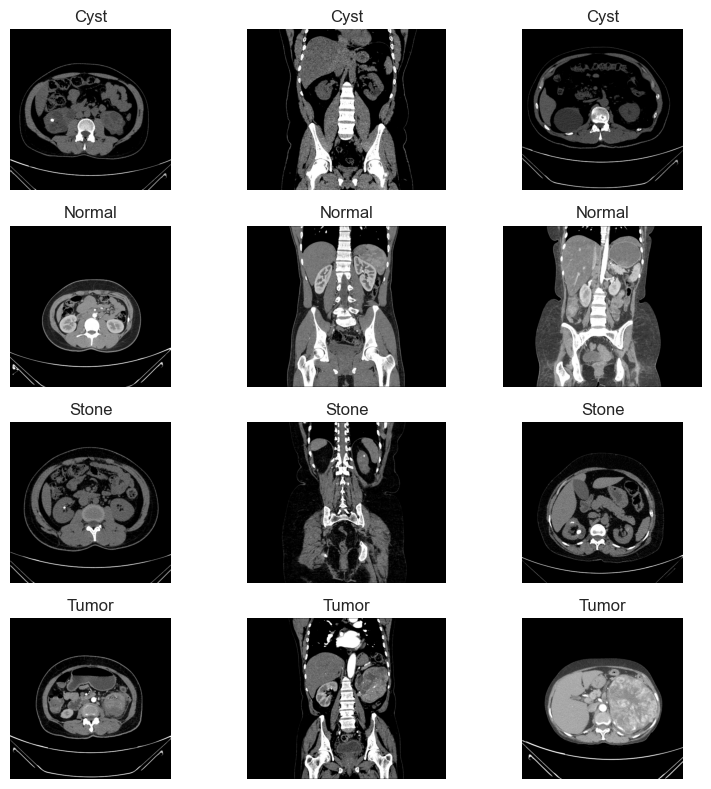

In [19]:
fig, axes = plt.subplots(4, 3, figsize=(8, 8))  
axes = axes.flatten()  

for i, label in enumerate(classes):
    class_data = df[df['label'] == label]
    sample_images = random.sample(list(class_data['file_path']), 3)
    
    for j, img_path in enumerate(sample_images):
        img = mpimg.imread(img_path) 
        axes[i * 3 + j].imshow(img)  
        axes[i * 3 + j].axis('off')  
        axes[i * 3 + j].set_title(label)  
plt.tight_layout()
plt.show()

In [20]:
 # Red channel

In [21]:
random_sample_row = df.sample(n=1)
image_path = random_sample_row['file_path'].values[0]

# image = cv2.imread(image_path)
image = plt.imread(image_path)

if np.all(image[:, :, 0] == image[:, :, 1]) and np.all(image[:, :, 1] == image[:, :, 2]):
    print("Image is black and white (3 channel grayscale).")
    print("Get or convert image to grayscale :)")
else:
    print("Image is color (RGB).")
    print("Image is really rgb dude I checked :')")

Image is black and white (3 channel grayscale).
Get or convert image to grayscale :)


The dimensions of the image are 512 pixels width and 512 pixels height, with 3 color channels.
The maximum pixel value is 255.0000 and the minimum is 0.0000
The mean value of the pixels is 17.4980 and the standard deviation is 39.5067


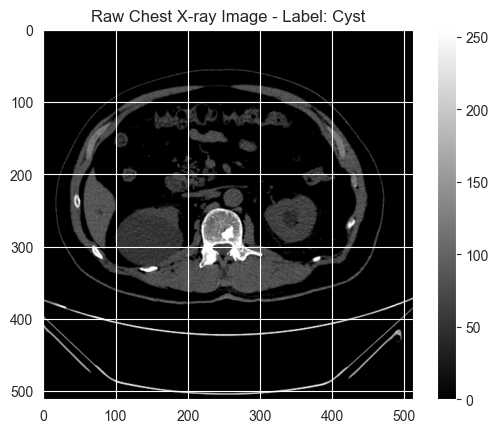

In [22]:
random_sample_row = df.sample(n=1)

image_path = random_sample_row['file_path'].values[0]
label = random_sample_row['label'].values[0]

sample_img = plt.imread(image_path)
plt.imshow(sample_img, cmap='gray')
plt.colorbar()
plt.title(f'Raw Chest X-ray Image - Label: {label}')

print(f"The dimensions of the image are {sample_img.shape[0]} pixels width and {sample_img.shape[1]} pixels height, with {sample_img.shape[2]} color channels.")
print(f"The maximum pixel value is {sample_img.max():.4f} and the minimum is {sample_img.min():.4f}")
print(f"The mean value of the pixels is {sample_img.mean():.4f} and the standard deviation is {sample_img.std():.4f}")

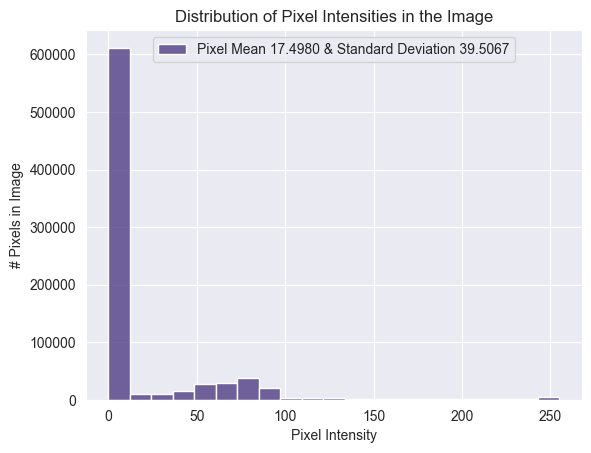

In [23]:
warnings.filterwarnings("ignore", message="use_inf_as_na option is deprecated")

# Replace inf with NaN
sample_img = np.where(np.isinf(sample_img), np.nan, sample_img)

# Plotting code (without the deprecated option)
sns.histplot(sample_img.ravel(),
             label=f"Pixel Mean {np.mean(sample_img):.4f} & Standard Deviation {np.std(sample_img):.4f}",
             kde=False)
plt.legend(loc='upper center')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')
plt.show()

In [24]:
df['binary_label'] = df['label'].apply(lambda x: "NORMAL" if x == 'Normal' else "ABNORMAL")

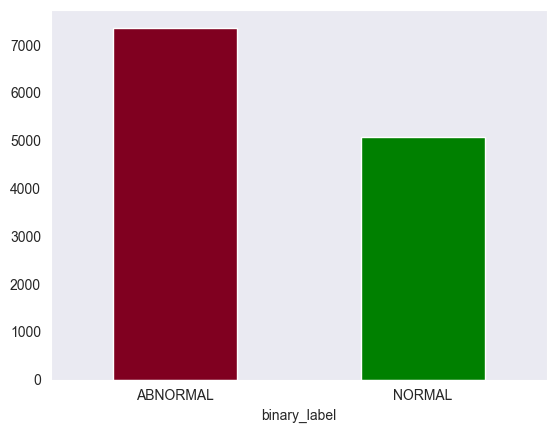

In [25]:
value_counts = df['binary_label'].value_counts()
ax = value_counts.plot(kind='bar', color=['#800020', 'green'])
plt.xticks(rotation=360)
plt.grid(False)

plt.show()

#PREPROCESSING

In [26]:
df["binary_label"] = df["label"].apply(lambda x: 0 if x == "Normal" else 1)

In [27]:
label_mapping = {"Normal" : 0, "Cyst": 1 , "Tumor": 2, "Stone": 3}
df["label"] = df["label"].map(label_mapping)


In [28]:
df

,file_path,label,binary_label
0,artifacts/data_ingestion/CT-KIDNEY-DATASET-Nor...,1,1
1,artifacts/data_ingestion/CT-KIDNEY-DATASET-Nor...,1,1
2,artifacts/data_ingestion/CT-KIDNEY-DATASET-Nor...,1,1
3,artifacts/data_ingestion/CT-KIDNEY-DATASET-Nor...,1,1
4,artifacts/data_ingestion/CT-KIDNEY-DATASET-Nor...,1,1
...,...,...,...
12441,artifacts/data_ingestion/CT-KIDNEY-DATASET-Nor...,2,1
12442,artifacts/data_ingestion/CT-KIDNEY-DATASET-Nor...,2,1
12443,artifacts/data_ingestion/CT-KIDNEY-DATASET-Nor...,2,1
12444,artifacts/data_ingestion/CT-KIDNEY-DATASET-Nor...,2,1


In [29]:
df['label'].value_counts()

label
0    5077
1    3709
2    2283
3    1377
Name: count, dtype: int64

In [30]:
train_df , temp_df = train_test_split(df, test_size = 0.3, random_state = 42, stratify = df["label"])
test_df, valid_df = train_test_split(temp_df, test_size = 0.3, random_state=42, stratify = temp_df["label"])

print("Training set shapes:",train_df.shape)
print("Training set shapes:",test_df.shape)
print("Training set shapes:",valid_df.shape)

Training set shapes: (8712, 3)
Training set shapes: (2613, 3)
Training set shapes: (1121, 3)


In [31]:
df

,file_path,label,binary_label
0,artifacts/data_ingestion/CT-KIDNEY-DATASET-Nor...,1,1
1,artifacts/data_ingestion/CT-KIDNEY-DATASET-Nor...,1,1
2,artifacts/data_ingestion/CT-KIDNEY-DATASET-Nor...,1,1
3,artifacts/data_ingestion/CT-KIDNEY-DATASET-Nor...,1,1
4,artifacts/data_ingestion/CT-KIDNEY-DATASET-Nor...,1,1
...,...,...,...
12441,artifacts/data_ingestion/CT-KIDNEY-DATASET-Nor...,2,1
12442,artifacts/data_ingestion/CT-KIDNEY-DATASET-Nor...,2,1
12443,artifacts/data_ingestion/CT-KIDNEY-DATASET-Nor...,2,1
12444,artifacts/data_ingestion/CT-KIDNEY-DATASET-Nor...,2,1


In [32]:
print("\nTraining Set class Distribution:")
print(train_df["label"].value_counts(normalize = True))
print(train_df["binary_label"].value_counts(normalize = True))

print("\nTesting Set class Distribution:")
print(test_df["label"].value_counts(normalize = True))
print(test_df["binary_label"].value_counts(normalize = True))

print("\nvalidation Set class Distribution:")
print(valid_df["label"].value_counts(normalize = True))
print(valid_df["binary_label"].value_counts(normalize = True))




Training Set class Distribution:
label
0    0.407943
1    0.297980
2    0.183425
3    0.110652
Name: proportion, dtype: float64
binary_label
1    0.592057
0    0.407943
Name: proportion, dtype: float64

Testing Set class Distribution:
label
0    0.407960
1    0.298125
2    0.183314
3    0.110601
Name: proportion, dtype: float64
binary_label
1    0.59204
0    0.40796
Name: proportion, dtype: float64

validation Set class Distribution:
label
0    0.407672
1    0.297948
2    0.183764
3    0.110616
Name: proportion, dtype: float64
binary_label
1    0.592328
0    0.407672
Name: proportion, dtype: float64


In [33]:
train_df['label'] = train_df['label'].astype(str)
test_df['label'] = test_df['label'].astype(str)
valid_df['label'] = valid_df['label'].astype(str)

train_df['binary_label'] = train_df['binary_label'].astype(str)
test_df['binary_label'] = test_df['binary_label'].astype(str)
valid_df['binary_label'] = valid_df['binary_label'].astype(str)

In [34]:
aug_image_generator = ImageDataGenerator(
    rescale=1.0/255,  # Scale pixel values  [0, 1]
    rotation_range=10,  # Small angle transformations
    width_shift_range=0.1,  # Small horizontal shifts
    height_shift_range=0.1,  # Small vertical shifts
    shear_range=0.1,  # Small shear transformations
    zoom_range=0.1,  # Small zoom
    horizontal_flip=True,  # Horizontal flip (for symmetrical structures)
    fill_mode='nearest',  # Fill gap method
)
ori_image_generator = ImageDataGenerator(
    rescale = 1.0/255
)

In [35]:
aug_training_set = aug_image_generator.flow_from_dataframe(
    dataframe = train_df,
    x_col = "file_path",
    y_col = "label",
    target_size = (224,224),
    batch_size=32,
    class_mode='categorical', 
    color_mode='grayscale',
    shuffle=True,
    seed = 42
)
ori_training_set = ori_image_generator.flow_from_dataframe(
    dataframe = train_df,
    x_col = "file_path",
    y_col = "label",
    target_size = (224,224),
    batch_size=32,
    class_mode='categorical', 
    color_mode='grayscale',
    shuffle=True,
    seed = 42
)

Found 8712 validated image filenames belonging to 4 classes.
Found 8712 validated image filenames belonging to 4 classes.


In [36]:
def combined_generator(aug_training_set, ori_training_set):
    n_orig = int(0.5 * len(aug_training_set))
    n_aug = len(aug_training_set) - n_orig
    
    while True:
        aug_images, aug_labels = next(aug_training_set)
        orig_images, orig_labels = next(ori_training_set)
        
        combined_images = np.concatenate((orig_images[:n_orig], aug_images[n_aug:]), axis=0)
        combined_labels = np.concatenate((orig_labels[:n_orig], aug_labels[n_aug:]), axis=0)
        
        yield combined_images, combined_labels
    

In [37]:
training_set = combined_generator(aug_training_set, ori_training_set)
training_set

<generator object combined_generator at 0x000001883205EF20>

In [38]:
validation_set = ori_image_generator.flow_from_dataframe(
    dataframe=valid_df,
    x_col='file_path', 
    y_col='label',
    target_size=(224, 224), 
    batch_size=32,
    color_mode='grayscale', # rgb renkli için 
    class_mode='categorical', # çoklu verin olduğu için categorical !!
    shuffle=False  
)

Found 1121 validated image filenames belonging to 4 classes.


In [39]:
validation_set

In [40]:
test_set = ori_image_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='file_path', 
    y_col='label',  
    target_size=(224, 224),  
    color_mode='grayscale', # önceden eğitilmiş modeller rgb bekliyor burada değişebilin
    batch_size=32,  
    class_mode='categorical', # binary eğer iki veri varsa 
    shuffle=False  
)

Found 2613 validated image filenames belonging to 4 classes.


In [41]:
print("Training set class distribution:")
print(ori_training_set.class_indices)
print(ori_training_set.classes[:20])
print(ori_training_set.samples)

print("\nTesting set class distribution:")
print(test_set.class_indices)
print(test_set.classes[0:20])
print(test_set.samples) 

print("\nValidation set class distribution:")
print(validation_set.class_indices)
print(validation_set.classes[0:20])
print(validation_set.samples) 

Training set class distribution:
{'0': 0, '1': 1, '2': 2, '3': 3}
[2, 2, 0, 0, 1, 0, 2, 0, 2, 0, 1, 0, 3, 1, 1, 2, 0, 1, 2, 0]
8712

Testing set class distribution:
{'0': 0, '1': 1, '2': 2, '3': 3}
[0, 0, 3, 0, 1, 0, 0, 0, 2, 0, 1, 1, 1, 0, 1, 1, 0, 1, 2, 1]
2613

Validation set class distribution:
{'0': 0, '1': 1, '2': 2, '3': 3}
[2, 1, 1, 0, 2, 1, 2, 1, 0, 1, 0, 3, 0, 0, 1, 2, 0, 0, 3, 0]
1121


In [42]:
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(ori_training_set.classes), y= ori_training_set.classes)
class_weights_dict = dict(zip(np.unique(ori_training_set.classes), class_weights))
class_weights_dict

{0: 0.6128306133933596,
 1: 0.8389830508474576,
 2: 1.362953692115144,
 3: 2.259336099585062}

In [60]:
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import Callback
def lr_schedule(epoch):
    initial_lr = 0.001
    drop_factor = 0.5
    drop_every = 5  # Her 5 epoch'ta bir öğrenme oranını yarıya düşür
    lr = initial_lr * (drop_factor ** (epoch // drop_every))
    return lr

class CustomObjectiveLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        acc_val = logs.get('val_accuracy', 0)
        acc_train = logs.get('accuracy', 0)
        loss_val = logs.get('val_loss', 0)
        loss_train = logs.get('loss', 0)

        loss_diff = abs(loss_val - loss_train)
        objective_value = acc_val - loss_diff
        logs['val_objective'] = objective_value
        print(f"Epoch {epoch + 1:05d}: Custom Objective = {objective_value:.6f}")
        print(f"  Training Accuracy =   {acc_train:.6f},Training Loss  = {loss_train:.6f}")
        print(f"  Validation Accuracy = {acc_val:.6f}, Validation Loss = {loss_val:.6f}")



model_checkpoint = ModelCheckpoint(
    filepath='best_model.keras', 
    monitor='val_objective', 
    save_best_only=True, 
    verbose=1, 
    mode='max',  # 'max' for accuracy, 'min' for loss
    save_freq='epoch',
    save_weights_only=False  # Tüm modeli kaydet
)


early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=20, 
    mode='max', 
    verbose=1, 
    restore_best_weights=True,
    baseline=0.99,  # Belirli bir doğruluk değerine ulaşılırsa durdur
    min_delta=0.001  # İyileşme bu değerden küçükse durdur
)


reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=3, 
    verbose=1, 
    mode='min', 
    min_delta=0.001, 
    cooldown=2, 
    min_lr=1e-6,
    #epsilon=0.001  # Öğrenme oranındaki değişiklik için eşik değer
)

#terminate_on_nan = TerminateOnNaN()
#lr_scheduler = LearningRateScheduler(lr_schedule)
#CSVLogger('training_log.csv', append=False)


callbacks = [
    CustomObjectiveLogger(),
    early_stopping,
    reduce_lr,
    model_checkpoint,
    # lr_scheduler,
    # csv_logger,
   #  terminate_on_nan
]

In [44]:
model = Sequential()

model.add(Conv2D(32, (3, 3), strides=(1, 1), padding='same', activation='relu', input_shape=(224, 224, 1)))
model.add(BatchNormalization())  
model.add(MaxPooling2D((2, 2), strides=(2, 2), padding='same'))  

model.add(Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(BatchNormalization())  
model.add(MaxPooling2D((2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(128, (3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(BatchNormalization())  
model.add(MaxPooling2D((2, 2), strides=(2, 2), padding='same'))

# flatten yerine 
model.add(GlobalAveragePooling2D())
# model.add(Flatten())  # Vektör haline getir

model.add(Dense(128, activation='relu'))  
model.add(BatchNormalization())  
model.add(Dropout(0.3))  

model.add(Dense(64, activation='relu'))  
model.add(BatchNormalization()) 
model.add(Dropout(0.3)) 

model.add(Dense(32, activation='relu')) 
model.add(BatchNormalization()) 
model.add(Dropout(0.3))  

model.add(Dense(4, activation='softmax'))  # softmax

model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # categorical_crossentropy
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 112, 112, 64)     256       
 hNormalization)                                                 
                                                        

In [149]:
history = model.fit(
    training_set,
    steps_per_epoch = ori_training_set.samples // ori_training_set.batch_size, 
    epochs=50,
    validation_data = validation_set,
    callbacks=callbacks,  
    class_weight=class_weights_dict,  # Sınıf ağırlıklarını ekleyin
    verbose=1
)

Epoch 1/50
272/272 [==============================] - ETA: 0s - loss: 1.1766 - accuracy: 0.5176
Epoch 00001: val_accuracy improved from -inf to 0.29795, saving model to best_model.keras
272/272 [==============================] - 116s 361ms/step - loss: 1.1766 - accuracy: 0.5176 - val_loss: 3.6303 - val_accuracy: 0.2979 - lr: 0.0010
Epoch 2/50
272/272 [==============================] - ETA: 0s - loss: 0.7924 - accuracy: 0.6881
Epoch 00002: val_accuracy did not improve from 0.29795
272/272 [==============================] - 114s 420ms/step - loss: 0.7924 - accuracy: 0.6881 - val_loss: 3.3326 - val_accuracy: 0.1302 - lr: 0.0010
Epoch 3/50
272/272 [==============================] - ETA: 0s - loss: 0.5498 - accuracy: 0.7993
Epoch 00003: val_accuracy improved from 0.29795 to 0.47458, saving model to best_model.keras
272/272 [==============================] - 102s 376ms/step - loss: 0.5498 - accuracy: 0.7993 - val_loss: 1.6322 - val_accuracy: 0.4746 - lr: 0.0010
Epoch 4/50
272/272 [==========

In [150]:
# Test verisi üzerinde değerlendirme
test_loss, test_accuracy = model.evaluate(test_set)
print(f"Test Accuracy: {test_accuracy:.5f}")
print(f"Test Loss: {test_loss:.5f}")

82/82 [==============================] - 13s 156ms/step - loss: 0.0013 - accuracy: 1.0000
Test Accuracy: 1.00000
Test Loss: 0.00129


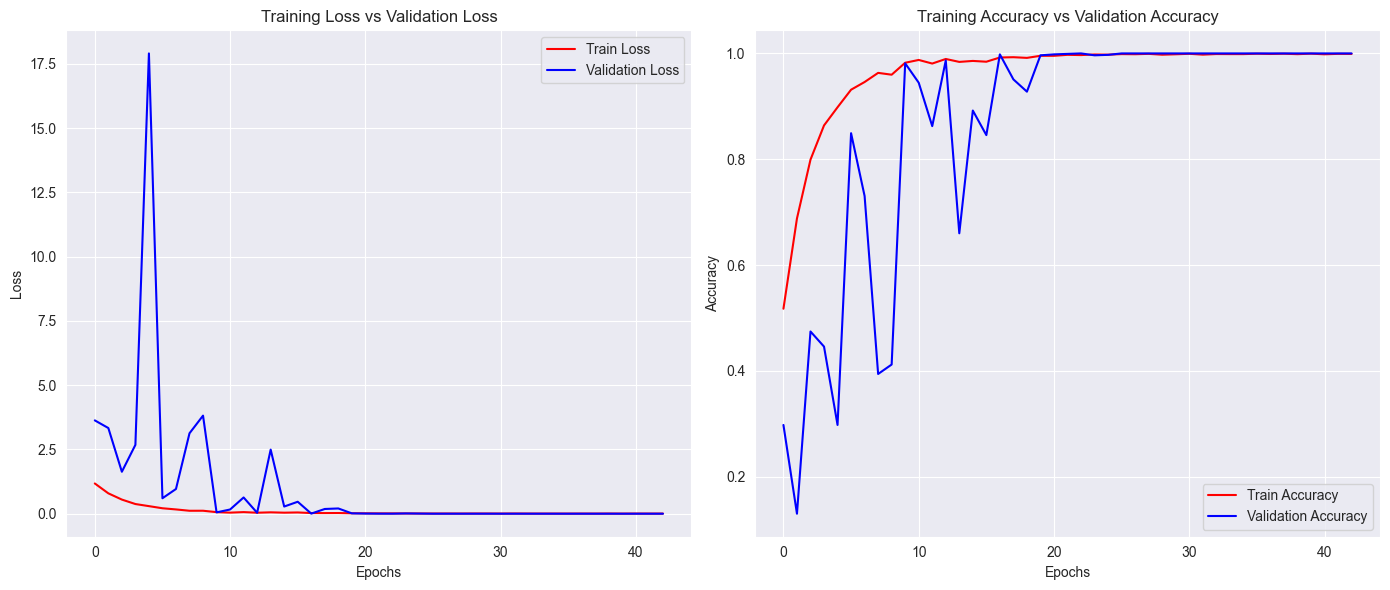

In [151]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].set_title('Training Loss vs Validation Loss')
ax[0].plot(history.history['loss'], color='red', label='Train Loss')
ax[0].plot(history.history['val_loss'], color='blue', label='Validation Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].set_title('Training Accuracy vs Validation Accuracy')
ax[1].plot(history.history['accuracy'], color='red', label='Train Accuracy')
ax[1].plot(history.history['val_accuracy'], color='blue', label='Validation Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.tight_layout()
plt.show()


In [153]:
model.save('aug&origi_base_training_model.keras')

In [162]:
from tensorflow.keras.preprocessing import image
model = load_model("aug&origi_base_training_model.keras")

# Define the image path
img_path = "research/CT-scan-of-the-abdomen-and-pelvis-showing-a-renal-stone-in-the-lower-pole-of-the-right.png"

# Load and preprocess the image
img = image.load_img(img_path, target_size=(224, 224), color_mode="grayscale")  # match your training size
img_array = image.img_to_array(img)
img_array = img_array / 255.0  # normalize if you used rescale=1./255 during training
img_array = np.expand_dims(img_array, axis=0)  # add batch dimension

# Predict
prediction = model.predict(img_array)
pred_index = np.argmax(prediction)

In [163]:
pred_index

3

# SAME TRAINING MODEL WITH ONLY ORIGINAL TRAINING DATA WITHOUT AUGMENTATION 

In [52]:
history = model.fit(
    ori_training_set,
    steps_per_epoch = ori_training_set.samples // ori_training_set.batch_size, 
    epochs=50,
    validation_data = validation_set,
    callbacks=callbacks,  
    class_weight=class_weights_dict,  # Sınıf ağırlıklarını ekleyin
    verbose=1
)

Epoch 1/50
272/272 [==============================] - ETA: 0s - loss: 1.0634 - accuracy: 0.5641
Epoch 00001: val_accuracy improved from -inf to 0.29795, saving model to best_model.keras
272/272 [==============================] - 60s 186ms/step - loss: 1.0634 - accuracy: 0.5641 - val_loss: 9.3168 - val_accuracy: 0.2979 - lr: 0.0010
Epoch 2/50
272/272 [==============================] - ETA: 0s - loss: 0.6962 - accuracy: 0.7263
Epoch 00002: val_accuracy did not improve from 0.29795
272/272 [==============================] - 50s 182ms/step - loss: 0.6962 - accuracy: 0.7263 - val_loss: 8.5545 - val_accuracy: 0.1106 - lr: 0.0010
Epoch 3/50
272/272 [==============================] - ETA: 0s - loss: 0.4909 - accuracy: 0.8218
Epoch 00003: val_accuracy did not improve from 0.29795
272/272 [==============================] - 51s 186ms/step - loss: 0.4909 - accuracy: 0.8218 - val_loss: 19.9938 - val_accuracy: 0.2971 - lr: 0.0010
Epoch 4/50
272/272 [==============================] - ETA: 0s - loss: 

In [53]:
# Test verisi üzerinde değerlendirme
test_loss, test_accuracy = model.evaluate(test_set)
print(f"Test Accuracy: {test_accuracy:.5f}")
print(f"Test Loss: {test_loss:.5f}")

82/82 [==============================] - 12s 138ms/step - loss: 0.0079 - accuracy: 0.9981
Test Accuracy: 0.99809
Test Loss: 0.00789


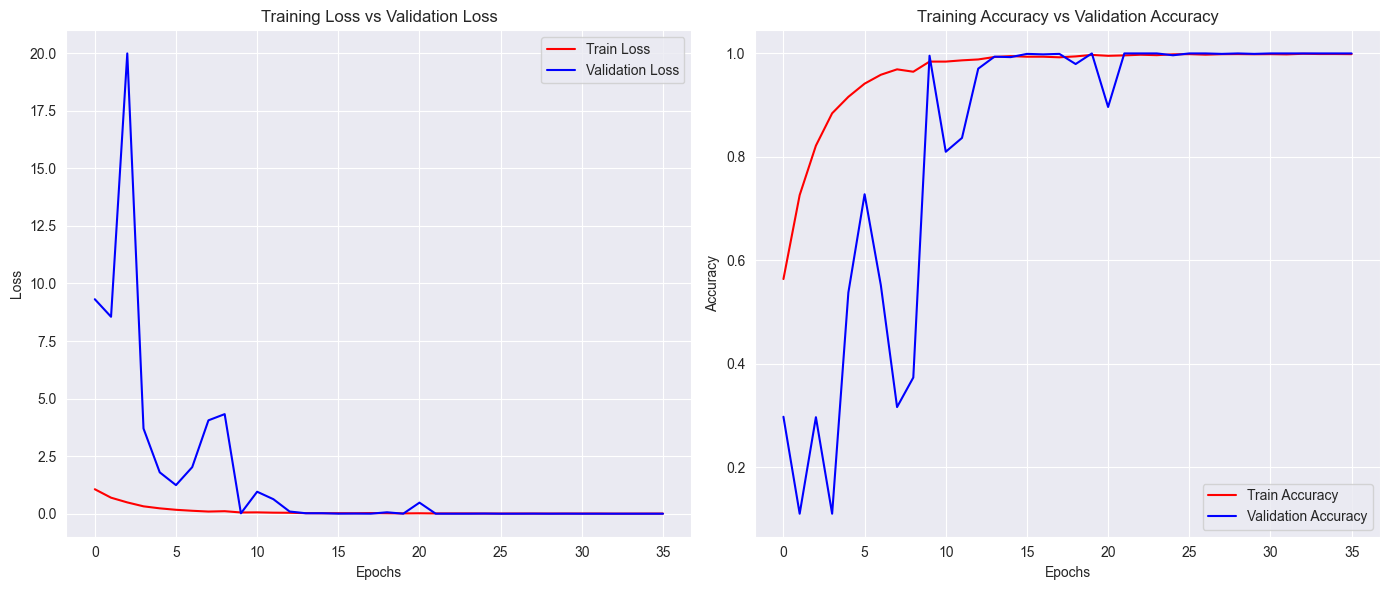

In [54]:
 fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].set_title('Training Loss vs Validation Loss')
ax[0].plot(history.history['loss'], color='red', label='Train Loss')
ax[0].plot(history.history['val_loss'], color='blue', label='Validation Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].set_title('Training Accuracy vs Validation Accuracy')
ax[1].plot(history.history['accuracy'], color='red', label='Train Accuracy')
ax[1].plot(history.history['val_accuracy'], color='blue', label='Validation Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.tight_layout()
plt.show()


In [55]:
model.save('only_origi_base_training_model.keras')

In [57]:
from tensorflow.keras.preprocessing import image
img_path = "research/CT-scan-of-the-abdomen-and-pelvis-showing-a-renal-stone-in-the-lower-pole-of-the-right.png"

# Load and preprocess the image
img = image.load_img(img_path, target_size=(224, 224), color_mode="grayscale")  # match your training size
img_array = image.img_to_array(img)
img_array = img_array / 255.0  # normalize if you used rescale=1./255 during training
img_array = np.expand_dims(img_array, axis=0)  # add batch dimension

# Predict
prediction = model.predict(img_array)
pred_index = np.argmax(prediction)

In [58]:
pred_index

3

# SAME TRAINING MODEL WITH ONLY  AUGMENTATION  DATA WITHOUT ORIGINAL TRAINING

In [59]:
history = model.fit(
    aug_training_set,
    steps_per_epoch = ori_training_set.samples // ori_training_set.batch_size, 
    epochs=50,
    validation_data = validation_set,
    callbacks=callbacks,  
    class_weight=class_weights_dict,  # Sınıf ağırlıklarını ekleyin
    verbose=1
)

Epoch 1/50
272/272 [==============================] - ETA: 0s - loss: 0.7660 - accuracy: 0.8346
Epoch 00001: val_accuracy did not improve from 1.00000
272/272 [==============================] - 62s 225ms/step - loss: 0.7660 - accuracy: 0.8346 - val_loss: 0.1785 - val_accuracy: 0.9554 - lr: 1.5625e-05
Epoch 2/50
272/272 [==============================] - ETA: 0s - loss: 0.5069 - accuracy: 0.8719
Epoch 00002: val_accuracy did not improve from 1.00000
272/272 [==============================] - 62s 227ms/step - loss: 0.5069 - accuracy: 0.8719 - val_loss: 0.1653 - val_accuracy: 0.9572 - lr: 1.5625e-05
Epoch 3/50
272/272 [==============================] - ETA: 0s - loss: 0.4838 - accuracy: 0.8710
Epoch 00003: val_accuracy did not improve from 1.00000
272/272 [==============================] - 68s 249ms/step - loss: 0.4838 - accuracy: 0.8710 - val_loss: 0.1803 - val_accuracy: 0.9554 - lr: 1.5625e-05
Epoch 4/50
272/272 [==============================] - ETA: 0s - loss: 0.4319 - accuracy: 0.879

In [61]:

# Test verisi üzerinde değerlendirme
test_loss, test_accuracy = model.evaluate(test_set)
print(f"Test Accuracy: {test_accuracy:.5f}")
print(f"Test Loss: {test_loss:.5f}")

82/82 [==============================] - 10s 122ms/step - loss: 0.2058 - accuracy: 0.9506
Test Accuracy: 0.95063
Test Loss: 0.20582


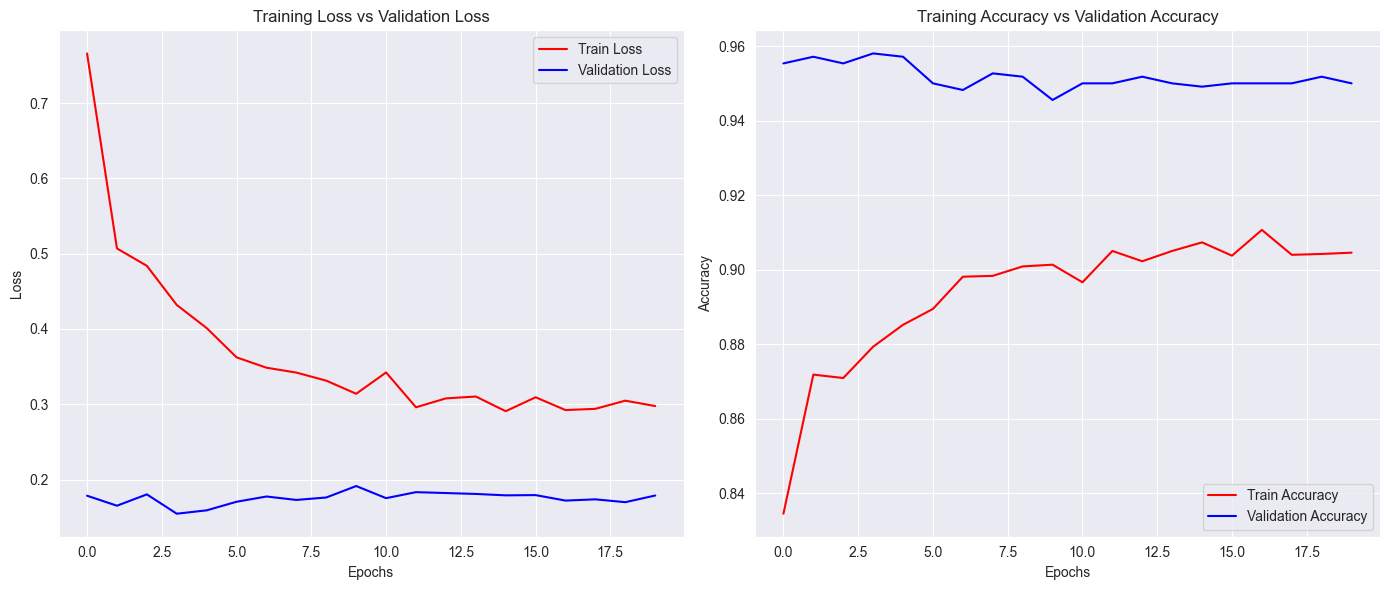

In [62]:
 fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].set_title('Training Loss vs Validation Loss')
ax[0].plot(history.history['loss'], color='red', label='Train Loss')
ax[0].plot(history.history['val_loss'], color='blue', label='Validation Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].set_title('Training Accuracy vs Validation Accuracy')
ax[1].plot(history.history['accuracy'], color='red', label='Train Accuracy')
ax[1].plot(history.history['val_accuracy'], color='blue', label='Validation Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.tight_layout()
plt.show()


In [45]:
pip install optuna

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\DIKSHANT PATEL\Kidney-Disease-Classification\.venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [46]:
import optuna

In [47]:
!pip install optuna-integration
from optuna.integration import TFKerasPruningCallback

You should consider upgrading via the 'C:\Users\DIKSHANT PATEL\Kidney-Disease-Classification\.venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [48]:
import mlflow
import mlflow.tensorflow

In [61]:
def create_model(trial):
    n_conv_layers = trial.suggest_int("n_conv_layers",3,6)
    n_dense_layers = trial.suggest_int("n_dense_layers", 2, 5)
    optimizer_name = trial.suggest_categorical('optimizer', ['adam','sgd'])
    strides_size = trial.suggest_categorical("strides_size",[(1, 1), (2,2)]) 
     
        # Initial filter list
    
    Allfilters = []
    
    # Add filter_0 manually if needed
    filter_0 = 32
    Allfilters.append(filter_0)
    
    if n_conv_layers == 6:
        filter6_1 = trial.suggest_categorical("filter6_1", [32, 64])
        filter6_2= 64
        filter6_3= trial.suggest_categorical("filter6_3", [64, 128])
        filter6_4= 128
        filter6_5 = 512
        Allfilters += [filter6_1, filter6_2, filter6_3, filter6_4, filter6_5]
    
    elif n_conv_layers == 5:
        filter5_1 = trial.suggest_categorical("filter5_1", [32, 64])
        filter5_2 = trial.suggest_categorical("filter5_2", [64, 128])
        filter5_3 = trial.suggest_categorical("filter5_3", [128, 512])
        filter5_4 = 512
        Allfilters += [filter5_1, filter5_2, filter5_3, filter5_4]
    
    elif n_conv_layers == 4:
        filter4_1 = trial.suggest_categorical("filter4_1", [32, 64])
        filter4_2 = 64
        filter4_3 = trial.suggest_categorical("filter4_3", [128, 512])
        Allfilters += [filter4_1, filter4_2, filter4_3]
    
    else:
        filter3_1 = trial.suggest_categorical("filter3_1", [32, 64])
        filter3_2 = trial.suggest_categorical("filter3_2", [64, 128])
        Allfilters += [filter3_1, filter3_2]
            
    
    model = Sequential()
    
    # First layer with input shape
    model.add(Conv2D(Allfilters[0], (3,3), strides=strides_size, activation='relu', padding='same', input_shape=(224, 224, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2,2), padding='same'))
    
    # Remaining conv layers
    for i in range(1, n_conv_layers):
        model.add(Conv2D(Allfilters[i], (3,3), strides=strides_size, activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2), strides=(2,2), padding='same'))
                    
    model.add(GlobalAveragePooling2D()) 
    
    Alldenseunits = []

    if n_dense_layers == 5:
        dense_units5_1 = trial.suggest_categorical("dense_units5_1", [256, 128])
        dense_units5_2 = trial.suggest_categorical("dense_units5_2", [128, 64])
        dense_units5_3 = trial.suggest_categorical("dense_units5_3", [64, 32])
        dense_units5_4 = trial.suggest_categorical("dense_units5_4", [32, 10])
        Alldenseunits = [dense_units5_1, dense_units5_2, dense_units5_3, dense_units5_4]
    
    elif n_dense_layers == 4:
        dense_units4_1 = trial.suggest_categorical("dense_units4_1", [256, 128])
        dense_units4_2 = trial.suggest_categorical("dense_units4_2", [128, 64])
        dense_units4_3 = trial.suggest_categorical("dense_units4_3", [64, 32])
        Alldenseunits = [dense_units4_1, dense_units4_2, dense_units4_3]
    
    elif n_dense_layers == 3:
        dense_units3_1 = trial.suggest_categorical("dense_units3_1", [128, 64])
        dense_units3_2 = trial.suggest_categorical("dense_units3_2", [64, 32])
        Alldenseunits = [dense_units3_1, dense_units3_2]
    
    else:
        dense_units2_1 = trial.suggest_categorical("dense_units2_1", [32, 64])
        Alldenseunits = [dense_units2_1]
    
    for units in Alldenseunits:
        model.add(Dense(units, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.3))
    
    model.add(Dense(4, activation='softmax')) 
        
    # Optimizer
    if optimizer_name == 'adam':
        optimizer = Adam(learning_rate=0.01)
    elif optimizer_name == 'sgd':
        optimizer = SGD(learning_rate=0.01, momentum= 0.9, nesterov=True)
    else:
        raise ValueError("Choose 'adam' or 'sgd' for optimizer_name")

    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [62]:
from mlflow.models import infer_signature
mlflow.set_tracking_uri("file:./mlruns")
mlflow.set_experiment("CNN_Optuna1_MLFLOW")

import gc
import tensorflow.keras.backend as K


def objective(trial):
    try:
        if mlflow.active_run():
           mlflow.end_run()
        input_example = np.random.rand(32, 224, 224, 1).astype(np.float32)
        output_example = np.random.rand(32, 4).astype(np.float32)
        with mlflow.start_run(run_name=f"trial_{trial.number}"):
            
            n_conv_layers = trial.suggest_int("n_conv_layers", 3, 6)
            n_dense_layers = trial.suggest_int("n_dense_layers", 2, 5)
            model = create_model(trial)
            # Log hyperparameters to MLflow
            for param_name, param_value in trial.params.items():
                mlflow.log_param(param_name, param_value)

            history = model.fit(
                training_set,
                steps_per_epoch=len(train_df) // 32,
                validation_data=validation_set,
                epochs=30,
                callbacks=callbacks,
                class_weight=class_weights_dict,
                verbose=0
            )
            # Log manually defined (static) parameters
            mlflow.log_param("image_size", "224x224x1")
            mlflow.log_param("filter_0", 32)
            mlflow.log_param("Batchsize", 32)
            mlflow.log_param("loss function" ,"categorical_crossentropy")
            
            if n_conv_layers == 6:
                mlflow.log_param("filter6_2", 64)
                mlflow.log_param("filter6_4", 128)
                mlflow.log_param("filter6_5", 512)
            if n_conv_layers == 5:
                mlflow.log_param("filter5_4", 512)
            if n_conv_layers == 4:
                mlflow.log_param("filter4_2", 64)
            if n_dense_layers == 5:
                mlflow.log_param("filter5_4", 512)
            mlflow.log_param(f"dense_units{n_dense_layers}_{n_dense_layers}", 4)   
            
            
            if np.any(np.isnan(history.history['loss'])) or np.any(np.isnan(history.history['val_loss'])):
                raise ValueError("NaN value encountered in loss or validation loss.")
            
            # Log the metrics (train and validation accuracy, loss)
            train_accuracy = max(history.history['accuracy'])  # or 'acc', depending on your Keras version
            train_loss = min(history.history['loss'])
            val_accuracy = max(history.history['val_accuracy'])
            val_loss = min(history.history['val_loss'])
            
            loss_train = history.history['loss'][-1]
            loss_val = history.history['val_loss'][-1]
            acc_val = history.history['val_accuracy'][-1]
            loss_diff = abs(loss_train - loss_val)
            objective_value = acc_val - loss_diff
           # Log metrics to MLflow
            mlflow.log_metric("train_accuracy", train_accuracy)
            mlflow.log_metric("train_loss", train_loss)
            mlflow.log_metric("val_accuracy", val_accuracy)
            mlflow.log_metric("val_loss", val_loss)
            mlflow.log_metric("acc_val - loss_diff", objective_value)
            
            signature = infer_signature(input_example, output_example)
            mlflow.tensorflow.log_model(model, artifact_path="model", signature = signature)

            return objective_value

    except Exception as e:
        print(f"[Trial Failed] Error: {e}")
        mlflow.log_param("failed_trial", True)
        mlflow.log_param("error_msg", str(e)[:500])
        return float("nan")

    finally:
        mlflow.end_run()
        try:
            del model
        except:
            pass
        K.clear_session()
        gc.collect()


In [ ]:
study = optuna.create_study(direction="maximize",
                            sampler=optuna.samplers.TPESampler())
with mlflow.start_run(run_name="Optuna_Study_Run_Custom_CNN"):
    study.optimize(objective, n_trials=30)
    mlflow.end_run()

[I 2025-04-19 20:58:28,593] A new study created in memory with name: no-name-0f1f8a1b-0a70-4b92-aa6f-5d515ecb0d30


Epoch 00001: Custom Objective = -0.807579
  Training Accuracy =   0.601613,Training Loss  = 0.954100
  Validation Accuracy = 0.305085, Validation Loss = 2.066763

Epoch 00001: val_objective improved from -inf to -0.80758, saving model to best_model.keras
Epoch 00002: Custom Objective = 0.776937
  Training Accuracy =   0.861406,Training Loss  = 0.386755
  Validation Accuracy = 0.846566, Validation Loss = 0.456384

Epoch 00002: val_objective improved from -0.80758 to 0.77694, saving model to best_model.keras


In [72]:
import gc
import tensorflow.keras.backend as K

# Delete model if defined
try:
    del model
except:
    pass

K.clear_session()
gc.collect()

100

In [70]:
# After optimization is complete
print("Number of finished trials:", len(study.trials))
print("Best trial:")
print("  Value:", study.best_trial.value)
print("  Params:", study.best_trial.params)


Number of finished trials: 5
Best trial:
  Value: 0.9864136287942529
  Params: {'n_conv_layers': 6, 'n_dense_layers': 2, 'optimizer': 'sgd', 'strides_size': (2, 2), 'filter6_1': 64, 'filter6_3': 64, 'dense_units2_1': 64}


In [73]:
df = study.trials_dataframe()
df

,number,value,datetime_start,datetime_complete,duration,params_dense_0,params_dense_units,params_dropout_rate,params_filters_0,params_filters_1,params_filters_2,params_filters_3,params_kernel_size,params_learning_rate,params_n_conv_layers,params_n_dense_layers,params_optimizer,state
0,0,0.952721,2025-04-16 19:23:28.381064,2025-04-17 00:29:04.710946,0 days 05:05:36.329882,32.0,256,0.274126,64,512,512.0,512.0,"(5, 5)",0.005430,4,3,adam,COMPLETE
1,1,NaN,2025-04-17 00:29:04.710946,2025-04-17 00:29:04.757751,0 days 00:00:00.046805,NaN,256,0.442796,64,256,NaN,NaN,"(3, 3)",0.006054,3,3,sgd,FAIL
